##### top

# Simulate potential span and range of reliabilities estimated using attenuation correction across days

This ntb looks at synthetic data following the *car matching* task and estimates the range of possible reliabilities that we could observe by chance if we use attenuation correction on two separate days. The idea is to check the effect of possible outliers that drove this reliability to be more than one in the original dataset.

* [Generate concat dataset with different splits into days](#Generate-concat-dataset-with-different-splits-into-days)
* [Run the same splitting simulation on real data](#Run-the-same-splitting-simulation-on-real-data)
    * [Car matching](#Car-matching)
    * [Emotion labelling](#Emotion-labelling)
    * [Emotion matching](#Emotion-matching)
    * [GFMT](#GFMT)
    * [PIM MC](#PIM-MC)
* [Use simulations of different Cs to get a range/CI for the curves](#Use-simulations-of-different-Cs-to-get-a-range/CI-for-the-curves)

In [1]:
import os, sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define path and name
csv_clean_data_path = "../Data/cleaned_CSV" 

path_results = "../Data/results"
path_meaning = os.path.join(path_results, "reliability_meaning")

# Importing module for functions
functions_modul =  "./functions"
sys.path.insert(0, functions_modul)

# import all processing and plotting functions
from reliability_functions import bin_samples_rand4, calculate_reliability_between_two_groups, extract_data
from data_processing_functions import process_and_concatenate_all_tasks

def get_true_correlation(r_xy_prime, r_xx_prime, r_yy_prime):
    return r_xy_prime/np.sqrt(r_xx_prime*r_yy_prime)

# load the real data
task_files = [
 'GFMT-cleaned_data.csv',
 'GFMT-cleaned_data_rep.csv',
 'PIM_MC-cleaned_data.csv',
 'PIM_MC-cleaned_data_rep.csv',
 'car_matching-cleaned_data.csv',
 'car_matching-cleaned_data_rep.csv',
 'emotion_labelling-cleaned_data.csv',
 'emotion_labelling_rep-cleaned_data.csv',
 'emotion_matching-cleaned_data.csv',
 'emotion_matching_rep-cleaned_data.csv',
]
print(len(task_files))

task_names = [
 'GFMT',
 'PIM_MC',
 'car_matching',
 'emotion_labelling',
 'emotion_matching',
]

print(f'Unique tasks: {len(task_names)}')

dataframe_list, dic_num_subjects_per_task, df_wide, df_normed_wide, completed_subjects, all_anything_subjects, VET_shared_subjects = process_and_concatenate_all_tasks(task_names, task_files, csv_clean_data_path)

# get car matching
df_car_matching = [x for x in dataframe_list if x.task.str.contains('car_matching').all()][0]

# do cleaning - drop participants whose difference in score on first and second step is large
# define threshold for removing outliers
std_thr = 2
# compute the score difference
tmp_score_diff = df_car_matching.loc[df_car_matching["form"]=="original", ["userID", "correct"]].groupby('userID').mean() - df_car_matching.loc[df_car_matching["form"]=="repetition", ["userID", "correct"]].groupby('userID').mean()
mu = tmp_score_diff.mean()[0]
std = tmp_score_diff.std()[0]
outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
df_car_matching_cleaned = df_car_matching[~df_car_matching['userID'].isin(outliers)]
print(f'Droping {len(outliers)} outliers')

N_car_matching = df_car_matching_cleaned['userID'].unique().size

# define the data
num_forms = 1 # to reproduce exactly what we had now
n_trials_per_form_car_matching = 40
means_car_matching_day1 = df_car_matching_cleaned.loc[df_car_matching_cleaned["form"]=="original"].groupby('userID').correct.mean()
means_car_matching_day2 = df_car_matching_cleaned.loc[df_car_matching_cleaned["form"]=="repetition"].groupby('userID').correct.mean()

assert len(means_car_matching_day1) == len(means_car_matching_day2) == N_car_matching

10
Unique tasks: 5
GFMT
Running total 157 participants (out of 238 in first repetition).
PIM_MC
Running total 152 participants (out of 249 in first repetition).
car_matching
Running total 173 participants (out of 250 in first repetition).
emotion_labelling
Test first set:  emotion_labelling
Series([], Name: userID, dtype: int64)

Test second set
Series([], Name: userID, dtype: int64)
Running all replicate studies with total 166 participants (out of 242 in first repetition) and 45 stimuli.
emotion_matching
Test first set:  emotion_matching
Series([], Name: userID, dtype: int64)

Test second set
Series([], Name: userID, dtype: int64)
Running total 161 participants (out of 249 in first repetition).


This should be as before: 10; then this is how many files is left and what they are:
 0 []

-->There are 130 subjects who have all the tasks.

-->There are 187 subjects who have all repetitions of at least one task.

-->There are 231 subjects who have at least one repetition of all tasks.
Dro

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.8362173883927009
Are correlations close: False
N=164


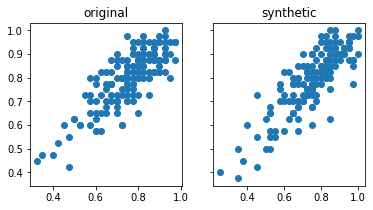

In [2]:
# generate data with the given statistics
rng_data = np.random.default_rng(1)
rng_data2 = np.random.default_rng(1)
# rng_data2 = rng_data
day1_array = bin_samples_rand4(rng_data, N_car_matching, num_forms*n_trials_per_form_car_matching, means_car_matching_day1.values, ravel=False)
day2_array = bin_samples_rand4(rng_data2, N_car_matching, num_forms*n_trials_per_form_car_matching, means_car_matching_day2.values, ravel=False)
print(f"Correlation in real data: {np.corrcoef(means_car_matching_day1, means_car_matching_day2)[0,1]}")
print(f"Correlation in simulated data: {np.corrcoef(day1_array.mean(axis=1), day2_array.mean(axis=1))[0,1]}")
print(f"Are correlations close: {np.isclose(means_car_matching_day1.corr(means_car_matching_day2), np.corrcoef(day1_array.mean(axis=1), day2_array.mean(axis=1))[0,1], atol=10**-3)}")
print(f"N={N_car_matching}")

fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
axs[0].scatter(means_car_matching_day1, means_car_matching_day2)
axs[1].scatter(day1_array.mean(axis=1), day2_array.mean(axis=1))
axs[0].set_title('original')
axs[1].set_title('synthetic')
plt.show()

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6157780166422642
Are correlations close: False
N=164


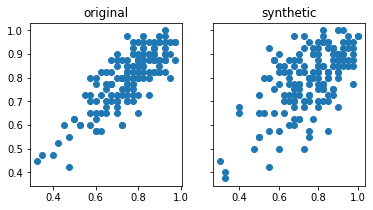

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.61163790402705
Are correlations close: False
N=164


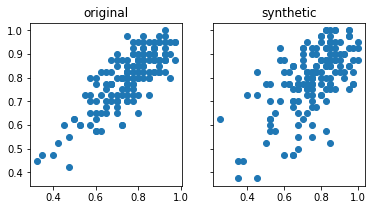

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6177406991453538
Are correlations close: False
N=164


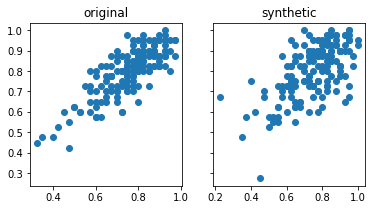

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6386154636667674
Are correlations close: False
N=164


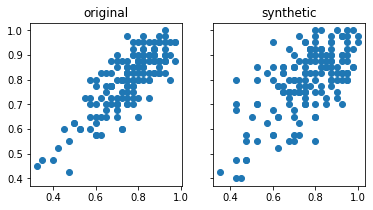

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6245800444619253
Are correlations close: False
N=164


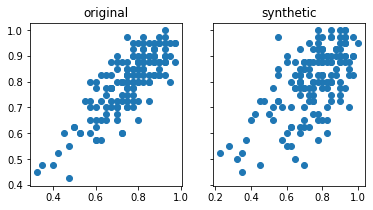

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6436435932941108
Are correlations close: False
N=164


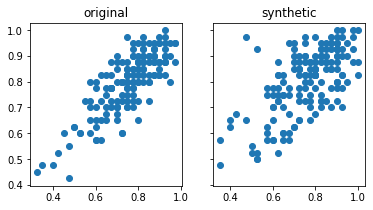

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6224552468725653
Are correlations close: False
N=164


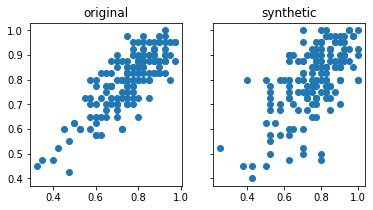

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.7081857733088711
Are correlations close: False
N=164


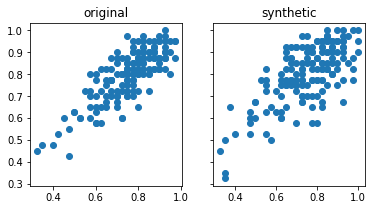

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.5365392166851503
Are correlations close: False
N=164


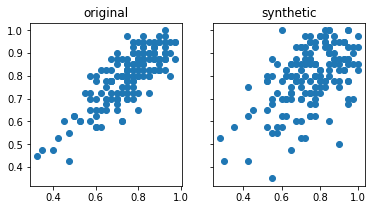

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6709617599741153
Are correlations close: False
N=164


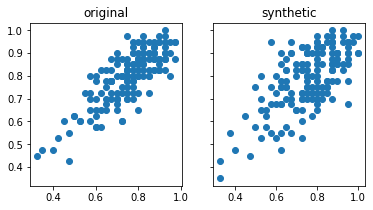

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6548519645592918
Are correlations close: False
N=164


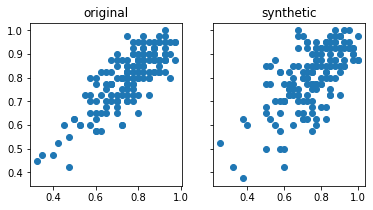

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6552329023248181
Are correlations close: False
N=164


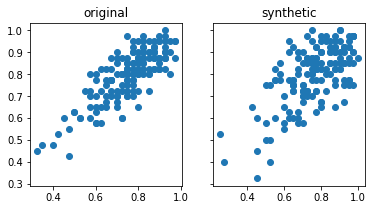

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6142068035347595
Are correlations close: False
N=164


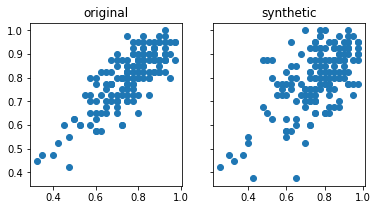

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6497870857395928
Are correlations close: False
N=164


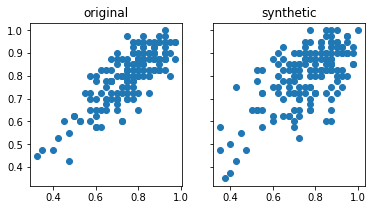

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6382193147556331
Are correlations close: False
N=164


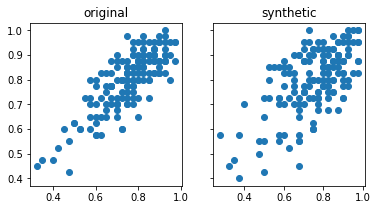

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.622953774911496
Are correlations close: False
N=164


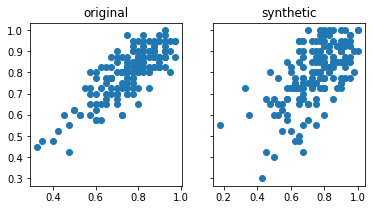

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6800760381196761
Are correlations close: False
N=164


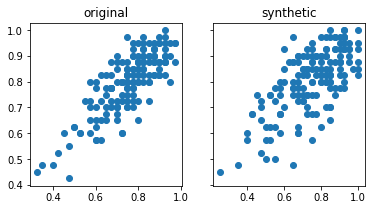

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6874116866906124
Are correlations close: False
N=164


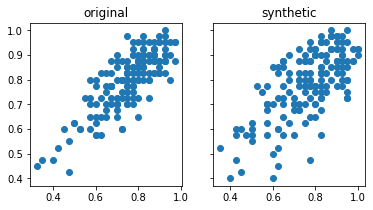

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6099570264441332
Are correlations close: False
N=164


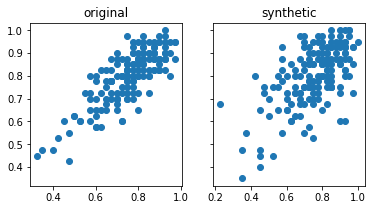

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6345647547453321
Are correlations close: False
N=164


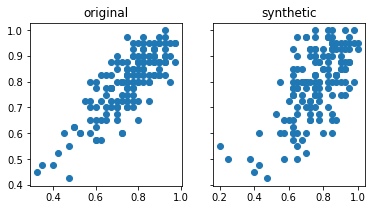

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6689771652172826
Are correlations close: False
N=164


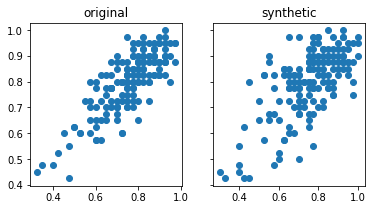

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6346437525437489
Are correlations close: False
N=164


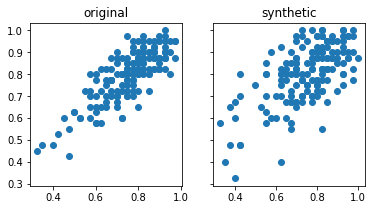

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6655930628024394
Are correlations close: False
N=164


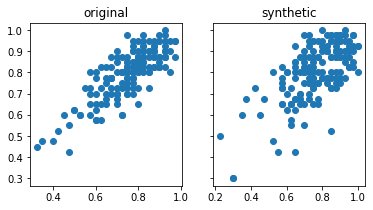

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6673947021634313
Are correlations close: False
N=164


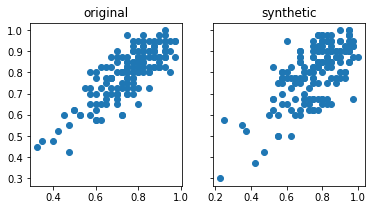

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6307372510259164
Are correlations close: False
N=164


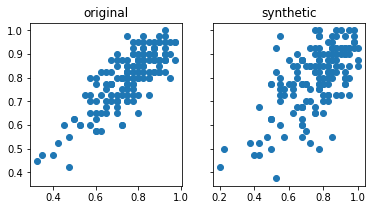

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6545217434911814
Are correlations close: False
N=164


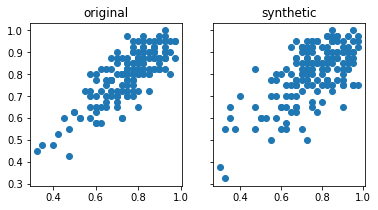

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6341876507193717
Are correlations close: False
N=164


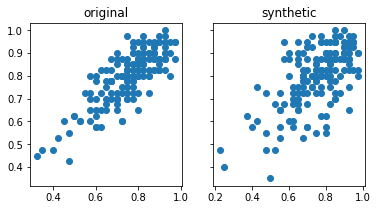

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.7047006714509157
Are correlations close: False
N=164


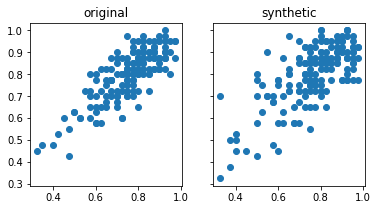

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6511997027422488
Are correlations close: False
N=164


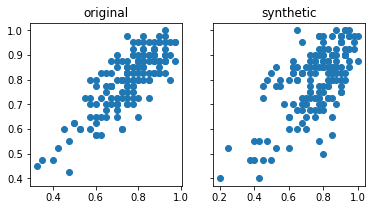

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.661968588804408
Are correlations close: False
N=164


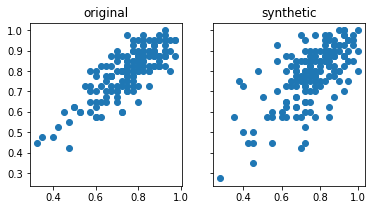

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.602359596613464
Are correlations close: False
N=164


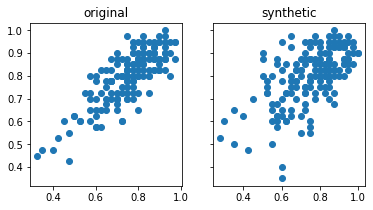

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.5906334579847884
Are correlations close: False
N=164


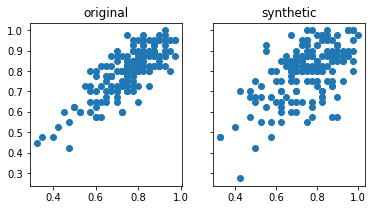

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6799424873150931
Are correlations close: False
N=164


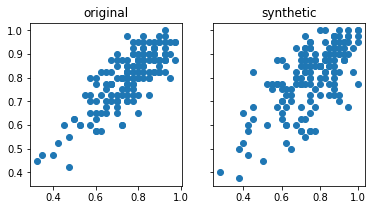

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6442691107252608
Are correlations close: False
N=164


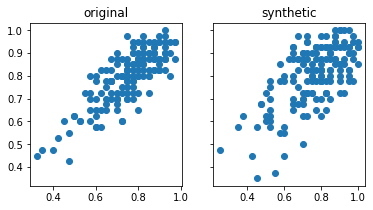

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6439650625897791
Are correlations close: False
N=164


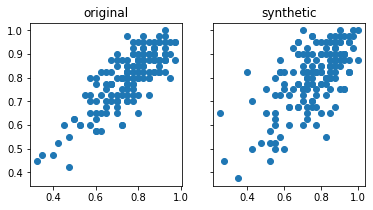

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6503647408664943
Are correlations close: False
N=164


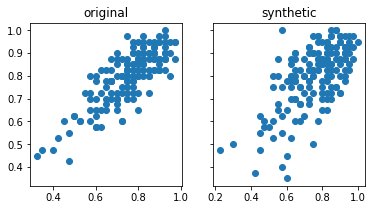

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6484056662717566
Are correlations close: False
N=164


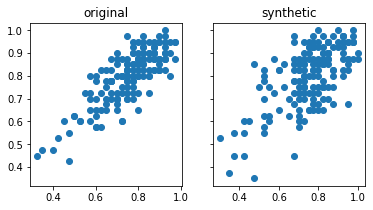

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6526385681100275
Are correlations close: False
N=164


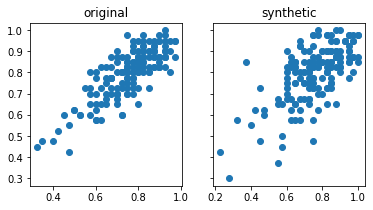

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6919696410205977
Are correlations close: False
N=164


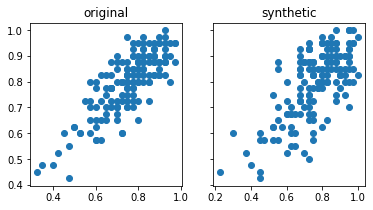

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.5842002509230126
Are correlations close: False
N=164


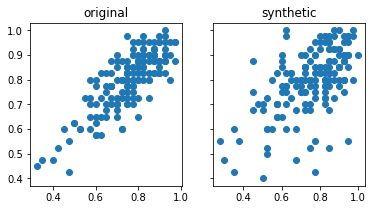

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6481006344730185
Are correlations close: False
N=164


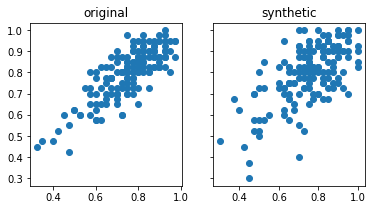

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6505796080662886
Are correlations close: False
N=164


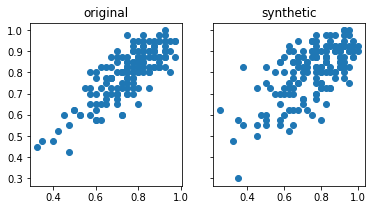

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6555733690066402
Are correlations close: False
N=164


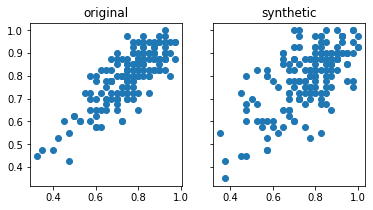

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.7051630826760573
Are correlations close: False
N=164


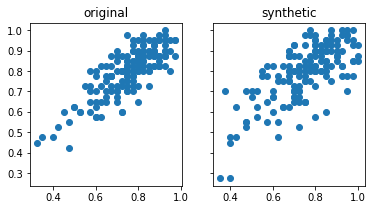

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.654284985608735
Are correlations close: False
N=164


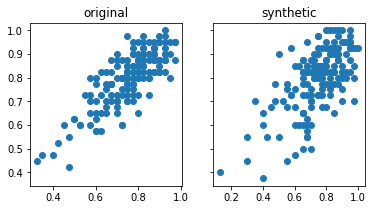

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6277008533137557
Are correlations close: False
N=164


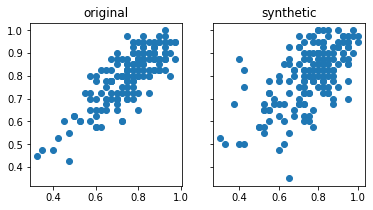

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6681691104210187
Are correlations close: False
N=164


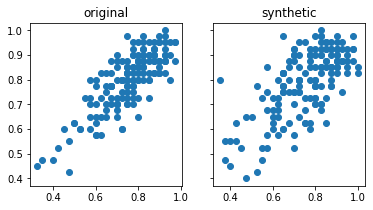

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.6255726574577164
Are correlations close: False
N=164


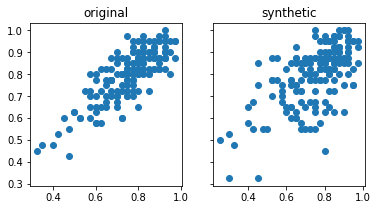

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.7171828744343134
Are correlations close: False
N=164


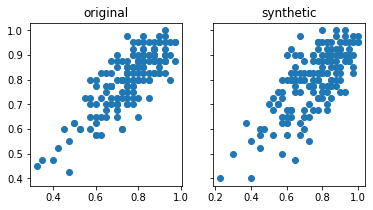

Correlation in real data: 0.8070839581448884
Correlation in simulated data: 0.5915510853994613
Are correlations close: False
N=164


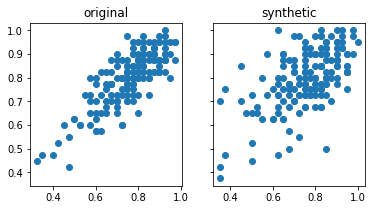

In [3]:
for i in range(50):
    # generate data with the given statistics
    rng_data = np.random.default_rng(i)
    rng_data2 = np.random.default_rng(i+1)
    # rng_data2 = rng_data
    day1_array = bin_samples_rand4(rng_data, N_car_matching, num_forms*n_trials_per_form_car_matching, means_car_matching_day1.values, ravel=False)
    day2_array = bin_samples_rand4(rng_data2, N_car_matching, num_forms*n_trials_per_form_car_matching, means_car_matching_day2.values, ravel=False)
    print(f"Correlation in real data: {np.corrcoef(means_car_matching_day1, means_car_matching_day2)[0,1]}")
    print(f"Correlation in simulated data: {np.corrcoef(day1_array.mean(axis=1), day2_array.mean(axis=1))[0,1]}")
    print(f"Are correlations close: {np.isclose(means_car_matching_day1.corr(means_car_matching_day2), np.corrcoef(day1_array.mean(axis=1), day2_array.mean(axis=1))[0,1], atol=10**-3)}")
    print(f"N={N_car_matching}")

    fig, axs = plt.subplots(1,2, figsize=(6,3), sharey=True)
    axs[0].scatter(means_car_matching_day1, means_car_matching_day2)
    axs[1].scatter(day1_array.mean(axis=1), day2_array.mean(axis=1))
    axs[0].set_title('original')
    axs[1].set_title('synthetic')
    plt.show()

In [4]:
n_iter = 100
# compute correlation in real data
real_data_corr = np.corrcoef(means_car_matching_day1, means_car_matching_day2)[0,1]

# calls the same seed twice
corr_diff_same_seed = np.zeros(n_iter)
# calls the same seed independently (two different generators with the same seed)
corr_diff_same_seed_independent = np.zeros(n_iter)
# calls a different seed
corr_diff_different_seed = np.zeros(n_iter)

for i in range(n_iter):
    # generate data with the given statistics
    rng_data = np.random.default_rng(i)
    rng_data2 = np.random.default_rng(i)
    rng_data3 = np.random.default_rng(i+n_iter)
    
    # generate data
    day1_array = bin_samples_rand4(rng_data, N_car_matching, num_forms*n_trials_per_form_car_matching, means_car_matching_day1.values, ravel=False)
    day2_array_s = bin_samples_rand4(rng_data, N_car_matching, num_forms*n_trials_per_form_car_matching, means_car_matching_day2.values, ravel=False)
    day2_array_i = bin_samples_rand4(rng_data2, N_car_matching, num_forms*n_trials_per_form_car_matching, means_car_matching_day2.values, ravel=False)
    day2_array_d = bin_samples_rand4(rng_data3, N_car_matching, num_forms*n_trials_per_form_car_matching, means_car_matching_day2.values, ravel=False)

    corr_diff_same_seed[i] = real_data_corr - np.corrcoef(day1_array.mean(axis=1), day2_array_s.mean(axis=1))[0,1]
    corr_diff_same_seed_independent[i] = real_data_corr - np.corrcoef(day1_array.mean(axis=1), day2_array_i.mean(axis=1))[0,1]
    corr_diff_different_seed[i] = real_data_corr - np.corrcoef(day1_array.mean(axis=1), day2_array_d.mean(axis=1))[0,1]
    
    

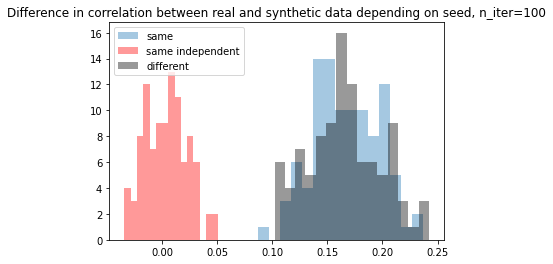

In [5]:
plt.hist(corr_diff_same_seed, alpha=0.4, bins=15, label='same')
plt.hist(corr_diff_same_seed_independent, alpha=0.4, bins=15, label='same independent', color='r')
plt.hist(corr_diff_different_seed, alpha=0.4, bins=15, label='different', color='k')

plt.legend()

plt.title(f'Difference in correlation between real and synthetic data depending on seed, n_iter={n_iter}')
plt.show()

## Generate concat dataset with different splits into days
[top](#top)

The idea of this code is to imagine we have the concatenated data and we want to check the effect of splitting it into days. 

The comparison we make in the analysis of the concat to get its reliability curve is different from the analysis for day 1 vs day 2, because there we "randomly" split the data, and then only sample within those splits. So it's possible that the difference we see between the curves is an artifact / result of this difference in analysis, and not that people are in fact different across days. The obvious control for this would be to split the real data into two along many different random splits, but this is difficult because the trials aren't actually the same, which is why we don't want to mix forms. This is why we decided to do this with simulations instead. 

The plan - generate synthetic data (with one generator and one seed because the null hypothesis we are testing is that there is no difference between the two halves of the data), and calculate the reliability of the concat and of split 1 vs split 2. The permutations on this could be either multiple generations, with one split each time, or one generation of data and multiple splits, or both.


In this case (noise that arises from the analysis of limited datasets) there is no reason to think one will be more highly correlated than the other (concat as opposed to day 1 vs day 2), the directionality in that assumption is the reason you are upset the ratio is above 1 to begin with
It will give us the range of ratios we expect to see when the trials truly all come from the same distribution

In [6]:
# define the data
num_forms = 2 # to reproduce exactly what we had now
n_trials_per_form_car_matching = 40
means_car_matching_concat = df_car_matching_cleaned.groupby('userID').correct.mean()

rng_data = np.random.default_rng(0)
concat_array = bin_samples_rand4(rng_data, N_car_matching, num_forms*n_trials_per_form_car_matching, means_car_matching_concat.values, ravel=False)

# print(concat_array.shape)
print(f"Mean in real data: {means_car_matching_concat.mean()}")
print(f"Mean in simulated data: {concat_array.mean()}")
print(f"Are means close: {np.isclose(means_car_matching_concat.mean(), concat_array.mean(), atol=10**-3)}")
print(f"N={N_car_matching}")

Mean in real data: 0.7762195121951219
Mean in simulated data: 0.7747713414634146
Are means close: False
N=164


In [7]:
# import numpy as np
# import timeit

# concat_array_shape = concat_array.shape[1]  # Adjust based on your actual array size

# def split_random():
#     indices1, indices2 = np.split(np.random.permutation(np.arange(concat_array_shape)), 2)

# def array_split():
#     random_idx = rng_split.choice(range(concat_array.shape[1]), n_trials_per_form_car_matching, replace=False)
#     random_idx2 = np.setdiff1d(np.arange(concat_array.shape[1]), random_idx)
    
# def array_split2():
#     random_idx = rng_split.choice(range(concat_array.shape[1]), n_trials_per_form_car_matching, replace=False)
#     random_idx2 = np.asarray(list(set(range(concat_array.shape[1])) - set(random_idx)))

# # Measure the execution time for split_random
# time_random = timeit.timeit(split_random, number=1000)

# # Measure the execution time for array_split
# time_array = timeit.timeit(array_split, number=1000)

# # Measure the execution time for array_split
# time_array2 = timeit.timeit(array_split2, number=1000)

# print(f"Time for split_random: {time_random:.6f} seconds")
# print(f"Time for array_split: {time_array:.6f} seconds")
# print(f"Time for array_split: {time_array2:.6f} seconds")


In [8]:
# do concat array separately

array_corr_fxn_concat, n_trials_list_concat = calculate_reliability_between_two_groups(concat_array, concat_array, num_forms*n_trials_per_form_car_matching)


Process took: 5.37 s which is 0.09 min.


In [9]:
# define how many times to split the data
n_splits = 50
n_repeats = 10**3

# predefine arrays
array_corr_fxn_orig = np.zeros((n_splits, 10, n_repeats))
array_corr_fxn_rep = np.zeros((n_splits, 10, n_repeats))
array_corr_fxn_orig_vs_rep = np.zeros((n_splits, 20, n_repeats))

# check 
assert n_trials_per_form_car_matching == concat_array.shape[1]//2

# start the timer
start = time.time()

for s in range(n_splits):
    # define random splitter
    rng_split = np.random.default_rng(s)
    
    # split the data into two days
    random_idx = rng_split.choice(range(concat_array.shape[1]), n_trials_per_form_car_matching, replace=False)
    random_idx2 = np.asarray(list(set(range(concat_array.shape[1])) - set(random_idx)))
#     random_idx, random_idx2 = np.split(np.random.permutation(np.arange(concat_array_shape)), 2)

    day1_array = concat_array[:, random_idx]
    day2_array = concat_array[:, random_idx2]

    ### Run analysis
    ## Short arrays
    array_corr_fxn_orig[s], n_trials_list_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_car_matching, n_repeats=n_repeats)
    array_corr_fxn_rep[s], n_trials_list_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_car_matching, n_repeats=n_repeats)

    ## Long arrays
    array_corr_fxn_orig_vs_rep[s], n_trials_list_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_car_matching, n_repeats=n_repeats)

    # and concat days
#     array_corr_fxn_concat, n_trials_list_concat = calculate_reliability_between_two_groups(all_trials_reshaped_concat, all_trials_reshaped_concat, total_n_trials_concat, step=step)



print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")

Process took: 2.50 s which is 0.04 min.
Process took: 2.42 s which is 0.04 min.
Process took: 4.74 s which is 0.08 min.
Process took: 2.54 s which is 0.04 min.
Process took: 2.50 s which is 0.04 min.
Process took: 5.30 s which is 0.09 min.
Process took: 2.51 s which is 0.04 min.
Process took: 2.48 s which is 0.04 min.
Process took: 4.91 s which is 0.08 min.
Process took: 2.46 s which is 0.04 min.
Process took: 2.44 s which is 0.04 min.
Process took: 4.84 s which is 0.08 min.
Process took: 2.50 s which is 0.04 min.
Process took: 2.49 s which is 0.04 min.
Process took: 4.72 s which is 0.08 min.
Process took: 2.45 s which is 0.04 min.
Process took: 2.45 s which is 0.04 min.
Process took: 4.82 s which is 0.08 min.
Process took: 2.52 s which is 0.04 min.
Process took: 2.52 s which is 0.04 min.
Process took: 5.14 s which is 0.09 min.
Process took: 2.58 s which is 0.04 min.
Process took: 2.46 s which is 0.04 min.
Process took: 4.81 s which is 0.08 min.
Process took: 2.50 s which is 0.04 min.


### Plot
[top](#top)

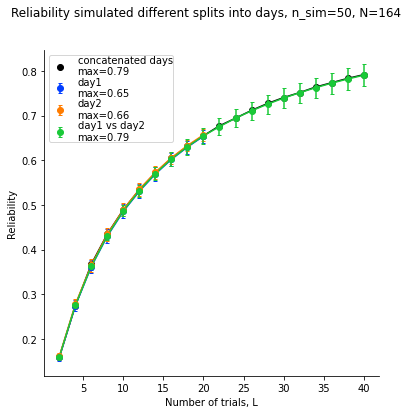

In [10]:

palette = sns.color_palette("bright", n_colors=3, as_cmap=False)

fig, ax = plt.subplots(1,1, figsize=(6,6))

# plt.subplots_adjust(hspace=0.4)



# add the full concatenated forms
ax.scatter(n_trials_list_concat, np.nanmean(array_corr_fxn_concat, axis=1), label=f'concatenated days\nmax={np.nanmean(array_corr_fxn_concat, axis=1).max():.2f}', color='k')
ax.plot(n_trials_list_concat, np.nanmean(array_corr_fxn_concat, axis=1), color='k')

# plot the individual plots
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_orig, n_trials_list_orig, 'day1'),
    (array_corr_fxn_rep, n_trials_list_rep, 'day2'),
    (array_corr_fxn_orig_vs_rep, n_trials_list_orig_vs_rep, 'day1 vs day2'),
]):
    arr = np.nanmean(arr, axis=-1)
#     ax.scatter(x_list, np.nanmean(arr, axis=0), label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}', color=palette[i])
    ax.plot(x_list, np.nanmean(arr, axis=0), color=palette[i])
    ax.errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, 
                c=palette[i], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')



ax.legend(columnspacing=0.01, labelspacing=0.01, borderpad=0.05)
# ax.set_title(f'{task}, N={tmp_dic["N"]}')



ax.set_ylabel('Reliability')
ax.set_xlabel('Number of trials, L')

sns.despine()

plt.suptitle(f'Reliability simulated different splits into days, n_sim={n_splits}, N={N_car_matching}')
plt.show()




In [11]:
# Add plot for the expected correlation
# check that the x ranges are the same
assert np.array_equal(n_trials_list_orig, n_trials_list_rep)
assert np.array_equal(n_trials_list_concat, n_trials_list_orig_vs_rep)


# # figure out maximal L that we have in both curves
# max_L = max(set(n_trials_list_orig)&set(n_trials_list_orig_vs_rep)) #max(np.intersect1d(tmp_dic['n_trials_list_orig'], tmp_dic['n_trials_list_orig_vs_rep']))


r_xy_array = np.zeros((n_splits, len(n_trials_list_orig)))

for i in range(n_splits):


    # get the true correlation
    r_xy_array[i] = get_true_correlation(
        np.nanmean(array_corr_fxn_orig_vs_rep[i, :len(n_trials_list_orig)], axis=1),
        np.nanmean(array_corr_fxn_orig[i], axis=1), 
        np.nanmean(array_corr_fxn_rep[i], axis=1)
    )

# # plot
# ax.axvline(max_L, c='grey', linestyle=':', label=f'max shared, L={max_L}')
# ax.axhline(r_xy, c='g', linestyle='-', label=f'true reliability={r_xy:.2f}')

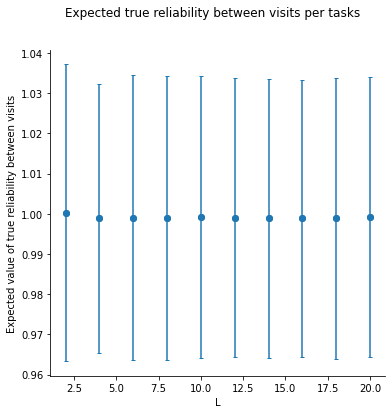

In [12]:
# get the true correlation
# r_xy = 
# palette = sns.color_palette("bright", n_colors=len(task4analysis), as_cmap=False)


fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(n_trials_list_orig, r_xy_array.mean(axis=0))
ax.errorbar(n_trials_list_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
ax.set_ylabel('Expected value of true reliability between visits')
ax.set_xlabel('L')

sns.despine()
# plt.legend(bbox_to_anchor=(1,1.05))
plt.suptitle(f'Expected true reliability between visits per tasks')
plt.show()

## Generate many concat datasets with one split into days
[top](#top)

## Run the same splitting simulation on real data
[top](#top)

In cases, where the trials are equivalent, where there is no difficulty between trials, we can try estimating the error directly on the data and split it several (hundred) times to see what range of errors we'd get.

### Car matching
[top](#top)

In [13]:
# extract data
car_matching_concat = extract_data(df_car_matching_cleaned.loc[:, ['userID', 'correct']], 
                                   num_forms*n_trials_per_form_car_matching, measure="correct")


# check
assert car_matching_concat.shape == concat_array.shape

In [14]:
# do concat array separately

array_corr_fxn_car_matching_concat, n_trials_list_car_matching_concat = calculate_reliability_between_two_groups(car_matching_concat, car_matching_concat, num_forms*n_trials_per_form_car_matching)


# define how many times to split the data
n_splits = 50
n_repeats = 10**3

# predefine arrays
array_corr_fxn_car_matching_orig = np.zeros((n_splits, 10, n_repeats))
array_corr_fxn_car_matching_rep = np.zeros((n_splits, 10, n_repeats))
array_corr_fxn_car_matching_orig_vs_rep = np.zeros((n_splits, 20, n_repeats))

# check 
assert n_trials_per_form_car_matching == car_matching_concat.shape[1]//2

# start the timer
start = time.time()

for s in range(n_splits):
    # define random splitter
    rng_split = np.random.default_rng(s)
    
    # split the data into two days
    random_idx = rng_split.choice(range(car_matching_concat.shape[1]), n_trials_per_form_car_matching, replace=False)
    random_idx2 = np.asarray(list(set(range(car_matching_concat.shape[1])) - set(random_idx)))
#     random_idx, random_idx2 = np.split(np.random.permutation(np.arange(car_matching_concat_shape)), 2)

    day1_array = car_matching_concat[:, random_idx]
    day2_array = car_matching_concat[:, random_idx2]

    ### Run analysis
    ## Short arrays
    array_corr_fxn_car_matching_orig[s], n_trials_list_car_matching_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_car_matching, n_repeats=n_repeats)
    array_corr_fxn_car_matching_rep[s], n_trials_list_car_matching_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_car_matching, n_repeats=n_repeats)

    ## Long arrays
    array_corr_fxn_car_matching_orig_vs_rep[s], n_trials_list_car_matching_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_car_matching, n_repeats=n_repeats)


    
# # Add the real split -- these two ways should be analogical and give the same arrays and results, but 
# # it depends on the sorting of the df and it sometimes behaves unpredictably, so I define it separately
# random_idx, random_idx2 = np.split(np.arange(car_matching_concat.shape[1]), 2)

# day1_array = car_matching_concat[:, random_idx]
# day2_array = car_matching_concat[:, random_idx2]
day1_array = extract_data(df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='original', ['userID', 'correct']], 
                                   n_trials_per_form_car_matching, measure="correct")
day2_array = extract_data(df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='repetition', ['userID', 'correct']], 
                                   n_trials_per_form_car_matching, measure="correct")


# ### Run analysis
# ## Short arrays
# array_corr_fxn_car_matching_orig_real, n_trials_list_car_matching_orig_real = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_car_matching, n_repeats=n_repeats)
# array_corr_fxn_car_matching_rep_real, n_trials_list_car_matching_rep_real = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_car_matching, n_repeats=n_repeats)

## Long arrays
array_corr_fxn_car_matching_orig_vs_rep_real, n_trials_list_car_matching_orig_vs_rep_real = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_car_matching, n_repeats=n_repeats)


print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")

Process took: 6.20 s which is 0.10 min.
Process took: 2.86 s which is 0.05 min.
Process took: 2.99 s which is 0.05 min.
Process took: 5.86 s which is 0.10 min.
Process took: 2.93 s which is 0.05 min.
Process took: 2.86 s which is 0.05 min.
Process took: 5.85 s which is 0.10 min.
Process took: 2.91 s which is 0.05 min.
Process took: 2.89 s which is 0.05 min.
Process took: 5.80 s which is 0.10 min.
Process took: 2.91 s which is 0.05 min.
Process took: 2.87 s which is 0.05 min.
Process took: 5.66 s which is 0.09 min.
Process took: 2.89 s which is 0.05 min.
Process took: 2.88 s which is 0.05 min.
Process took: 5.68 s which is 0.09 min.
Process took: 2.92 s which is 0.05 min.
Process took: 2.89 s which is 0.05 min.
Process took: 5.72 s which is 0.10 min.
Process took: 2.95 s which is 0.05 min.
Process took: 2.96 s which is 0.05 min.
Process took: 5.73 s which is 0.10 min.
Process took: 2.88 s which is 0.05 min.
Process took: 3.03 s which is 0.05 min.
Process took: 6.17 s which is 0.10 min.


#### Plot

In [15]:
# # Add the real split
# random_idx, random_idx2 = np.split(np.arange(car_matching_concat.shape[1]), 2)

# day1_array = car_matching_concat[:, random_idx]
# day2_array = car_matching_concat[:, random_idx2]

# # ### Run analysis
# # ## Short arrays
# # array_corr_fxn_car_matching_orig_real, n_trials_list_car_matching_orig_real = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_car_matching, n_repeats=n_repeats)
# # array_corr_fxn_car_matching_rep_real, n_trials_list_car_matching_rep_real = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_car_matching, n_repeats=n_repeats)


# # day1_array = extract_data(df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='original', ['userID', 'correct']], 
# #                                    n_trials_per_form_car_matching, measure="correct")
# # day2_array = extract_data(df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='repetition', ['userID', 'correct']], 
# #                                    n_trials_per_form_car_matching, measure="correct")
    

# ## Long arrays
# array_corr_fxn_car_matching_orig_vs_rep_real, n_trials_list_car_matching_orig_vs_rep_real = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_car_matching, n_repeats=n_repeats)


In [16]:
# df_sorted.sort_values(by='userID', ignore_index=False)

In [17]:
# df_car_matching_cleaned.sort_values(by=['userID', 'form']).sort_values(by='userID', kind='stable').equals(df_car_matching_cleaned.sort_values(by=['userID', 'form']))

In [18]:
# df_sorted = df_car_matching_cleaned.sort_values(by=['userID', 'form'])

# # df_sorted.sort_values(by='userID', ignore_index=True, inplace=True)

# arr = df_sorted.loc[:, 'correct'].values.reshape(df_sorted['userID'].unique().size, num_forms*n_trials_per_form_car_matching)

# np.all(df_car_matching_cleaned.loc[df_car_matching_cleaned['userID']=='s_1', 'correct'].values == arr, axis=1)


In [19]:
# arr[0] == df_car_matching_cleaned.loc[df_car_matching_cleaned['userID']=='s_1', 'correct'].values

In [20]:
# car_matching_concat = extract_data(df_sorted.loc[:, ['userID', 'correct']],
#                                    num_forms*n_trials_per_form_car_matching, measure="correct")

# car_matching_concat[0] == arr[0]

In [21]:
# is_x_in_car_matching_concat = np.all(x == car_matching_concat, axis=1)

# # Find the indices where x is located
# indices = np.where(is_x_in_car_matching_concat)[0]

In [22]:
# car_matching_concat = extract_data(df_car_matching_cleaned.loc[:, ['userID', 'correct']], 
#                                    num_forms*n_trials_per_form_car_matching, measure="correct")

In [23]:
# # np.all(df_sorted.loc[df_sorted['userID']=='s_3', 'correct'].values == car_matching_concat, axis=1)
# # np.all(df_car_matching_cleaned.loc[df_car_matching_cleaned['userID']=='s_3', 'correct'].values == car_matching_concat, axis=1)
# np.all(df_car_matching_cleaned.loc[df_car_matching_cleaned['userID']=='s_1', 'correct'].values == arr, axis=1)


In [24]:
# df_sorted.loc[df_sorted['userID']=='s_3', 'correct'].values

In [25]:
# df_sorted = df_car_matching_cleaned.sort_values(by=['userID', 'form'])

# day1_array = extract_data(df_sorted.loc[df_sorted['form']=='original', ['userID', 'correct']], 
#                                    n_trials_per_form_car_matching, measure="correct")
# day2_array = extract_data(df_sorted.loc[df_sorted['form']=='repetition', ['userID', 'correct']], 
#                                    n_trials_per_form_car_matching, measure="correct")


# car_matching_concat = extract_data(df_sorted.loc[:, ['userID', 'correct']],
#                                    num_forms*n_trials_per_form_car_matching, measure="correct")

# np.concatenate([day1_array, day2_array], axis=1)==car_matching_concat

In [26]:
# day1_array = extract_data(df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='original', ['userID', 'correct']], 
#                                    n_trials_per_form_car_matching, measure="correct")
# day2_array = extract_data(df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='repetition', ['userID', 'correct']], 
#                                    n_trials_per_form_car_matching, measure="correct")


# car_matching_concat = extract_data(df_car_matching_cleaned.sort_values(by=['userID', 'form']).loc[:, ['userID', 'correct']],
#                                    num_forms*n_trials_per_form_car_matching, measure="correct")

In [27]:
# # (np.concatenate([day1_array, day2_array], axis=1)!=car_matching_concat).sum()
# np.concatenate([day1_array, day2_array], axis=1)==car_matching_concat

In [28]:
# # car_matching_concat = extract_data(df_car_matching_cleaned.loc[:, ['userID', 'correct']], 
# #                                    num_forms*n_trials_per_form_car_matching, measure="correct")

# car_matching_concat = extract_data(df_car_matching_cleaned.sort_values(by=['userID', 'form']).loc[:, ['userID', 'correct']],
#                                    num_forms*n_trials_per_form_car_matching, measure="correct")

# # car_matching_concat = extract_data(
# #     pd.concat([df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='original', ['userID', 'correct']], 
# #                 df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='repetition', ['userID', 'correct']], 
# #               ]),
# #                                    num_forms*n_trials_per_form_car_matching, measure="correct")


In [29]:
# (day1_array != extract_data(df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='original', ['userID', 'correct']], 
#                                    n_trials_per_form_car_matching, measure="correct")).sum()
    

In [30]:
# day2_array == extract_data(df_car_matching_cleaned.loc[df_car_matching_cleaned['form']=='repetition', ['userID', 'correct']], 
#                                    n_trials_per_form_car_matching, measure="correct")
    

In [31]:
# car_matching_concat[:, random_idx] == day1_array

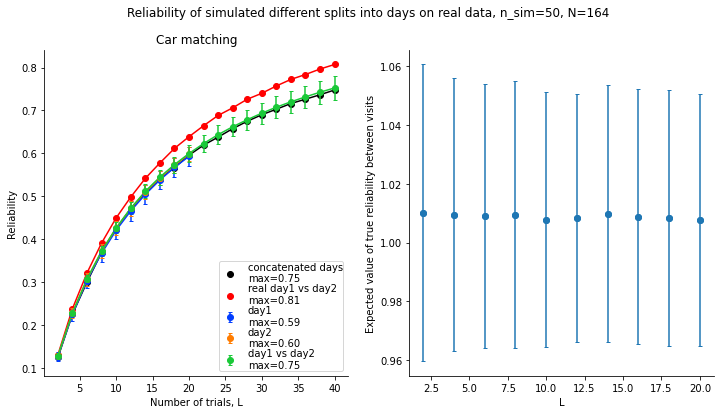

In [32]:
# define a dictionary for all the true reliabilities
dic_true_reliabilities_tasks = {}


palette = sns.color_palette("bright", n_colors=3, as_cmap=False)

fig, axs = plt.subplots(1,2, figsize=(12,6))

# plt.subplots_adjust(hspace=0.4)

# add the full concatenated forms
axs[0].scatter(n_trials_list_car_matching_concat, np.nanmean(array_corr_fxn_car_matching_concat, axis=1), label=f'concatenated days\nmax={np.nanmean(array_corr_fxn_car_matching_concat, axis=1).max():.2f}', color='k')
axs[0].plot(n_trials_list_car_matching_concat, np.nanmean(array_corr_fxn_car_matching_concat, axis=1), color='k')

# add the real split
axs[0].scatter(n_trials_list_car_matching_orig_vs_rep_real, np.nanmean(array_corr_fxn_car_matching_orig_vs_rep_real, axis=1), label=f'real day1 vs day2\nmax={np.nanmean(array_corr_fxn_car_matching_orig_vs_rep_real, axis=1).max():.2f}', color='r')
axs[0].plot(n_trials_list_car_matching_orig_vs_rep_real, np.nanmean(array_corr_fxn_car_matching_orig_vs_rep_real, axis=1), color='r')

# plot the individual plots
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_car_matching_orig, n_trials_list_car_matching_orig, 'day1'),
    (array_corr_fxn_car_matching_rep, n_trials_list_car_matching_rep, 'day2'),
    (array_corr_fxn_car_matching_orig_vs_rep, n_trials_list_car_matching_orig_vs_rep, 'day1 vs day2'),
]):
    arr = np.nanmean(arr, axis=-1)
#     axs[0].scatter(x_list, np.nanmean(arr, axis=0), label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}', color=palette[i])
    axs[0].plot(x_list, np.nanmean(arr, axis=0), color=palette[i])
    axs[0].errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, 
                c=palette[i], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')



axs[0].legend(columnspacing=0.01, labelspacing=0.01, borderpad=0.05)
# axs[0].set_title(f'{task}, N={tmp_dic["N"]}')


axs[0].set_ylabel('Reliability')
axs[0].set_xlabel('Number of trials, L')
axs[0].set_title('Car matching')


# Add plot for the expected correlation
# check that the x ranges are the same
assert np.array_equal(n_trials_list_car_matching_orig, n_trials_list_car_matching_rep)
assert np.array_equal(n_trials_list_car_matching_concat, n_trials_list_car_matching_orig_vs_rep)


# # figure out maximal L that we have in both curves
# max_L = max(set(n_trials_list_car_matching_orig)&set(n_trials_list_car_matching_orig_vs_rep)) #max(np.intersect1d(tmp_dic['n_trials_list_car_matching_orig'], tmp_dic['n_trials_list_car_matching_orig_vs_rep']))


r_xy_array = np.zeros((n_splits, len(n_trials_list_car_matching_orig)))

for i in range(n_splits):


    # get the true correlation
    r_xy_array[i] = get_true_correlation(
        np.nanmean(array_corr_fxn_car_matching_orig_vs_rep[i, :len(n_trials_list_car_matching_orig)], axis=1),
        np.nanmean(array_corr_fxn_car_matching_orig[i], axis=1), 
        np.nanmean(array_corr_fxn_car_matching_rep[i], axis=1)
    )

# save it
dic_true_reliabilities_tasks['Car matching'] = r_xy_array

axs[1].scatter(n_trials_list_car_matching_orig, r_xy_array.mean(axis=0))
axs[1].errorbar(n_trials_list_car_matching_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
axs[1].set_ylabel('Expected value of true reliability between visits')
axs[1].set_xlabel('L')

sns.despine()
# axs[1].set_title(f'Expected true reliability between visits per tasks')


plt.suptitle(f'Reliability of simulated different splits into days on real data, n_sim={n_splits}, N={N_car_matching}')
plt.show()

### Emotion labelling
[top](#top)

In [33]:
# get car matching
df_emotion_labelling = [x for x in dataframe_list if x.task.str.contains('emotion_labelling').all()][0]

# do cleaning - drop participants whose difference in score on first and second step is large
# define threshold for removing outliers
std_thr = 2
# compute the score difference
tmp_score_diff = df_emotion_labelling.loc[df_emotion_labelling["form"]=="original", ["userID", "correct"]].groupby('userID').mean() - df_emotion_labelling.loc[df_emotion_labelling["form"]=="repetition", ["userID", "correct"]].groupby('userID').mean()
mu = tmp_score_diff.mean()[0]
std = tmp_score_diff.std()[0]
outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
df_emotion_labelling_cleaned = df_emotion_labelling[~df_emotion_labelling['userID'].isin(outliers)]
print(f'Droping {len(outliers)} outliers')

N_emotion_labelling = df_emotion_labelling_cleaned['userID'].unique().size

# define the data
num_forms = 2
n_trials_per_form_emotion_labelling = 45

# extract data
emotion_labelling_concat = extract_data(df_emotion_labelling_cleaned.loc[:, ['userID', 'correct']], 
                                   num_forms*n_trials_per_form_emotion_labelling, measure="correct")



Droping 7 outliers


In [34]:
# do concat array separately

array_corr_fxn_emotion_labelling_concat, n_trials_list_emotion_labelling_concat = calculate_reliability_between_two_groups(emotion_labelling_concat, emotion_labelling_concat, num_forms*n_trials_per_form_emotion_labelling)


# define how many times to split the data
n_splits = 50
n_repeats = 10**3

# predefine arrays
array_corr_fxn_emotion_labelling_orig = np.zeros((n_splits, 11, n_repeats))
array_corr_fxn_emotion_labelling_rep = np.zeros((n_splits, 11, n_repeats))
array_corr_fxn_emotion_labelling_orig_vs_rep = np.zeros((n_splits, 22, n_repeats))

# check 
assert n_trials_per_form_emotion_labelling == emotion_labelling_concat.shape[1]//2

# start the timer
start = time.time()

for s in range(n_splits):
    # define random splitter
    rng_split = np.random.default_rng(s)
    
    # split the data into two days
    random_idx = rng_split.choice(range(emotion_labelling_concat.shape[1]), n_trials_per_form_emotion_labelling, replace=False)
    random_idx2 = np.asarray(list(set(range(emotion_labelling_concat.shape[1])) - set(random_idx)))
#     random_idx, random_idx2 = np.split(np.random.permutation(np.arange(emotion_labelling_concat_shape)), 2)

    day1_array = emotion_labelling_concat[:, random_idx]
    day2_array = emotion_labelling_concat[:, random_idx2]

    ### Run analysis
    ## Short arrays
    array_corr_fxn_emotion_labelling_orig[s], n_trials_list_emotion_labelling_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_emotion_labelling, n_repeats=n_repeats)
    array_corr_fxn_emotion_labelling_rep[s], n_trials_list_emotion_labelling_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_emotion_labelling, n_repeats=n_repeats)

    ## Long arrays
    array_corr_fxn_emotion_labelling_orig_vs_rep[s], n_trials_list_emotion_labelling_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_emotion_labelling, n_repeats=n_repeats)

    

# Add the real split
day1_array = extract_data(df_emotion_labelling_cleaned.loc[df_emotion_labelling_cleaned['form']=='original', ['userID', 'correct']], 
                                   n_trials_per_form_emotion_labelling, measure="correct")
day2_array = extract_data(df_emotion_labelling_cleaned.loc[df_emotion_labelling_cleaned['form']=='repetition', ['userID', 'correct']], 
                                   n_trials_per_form_emotion_labelling, measure="correct")

# ### Run analysis
# ## Short arrays
# array_corr_fxn_emotion_labelling_orig_real, n_trials_list_emotion_labelling_orig_real = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_emotion_labelling, n_repeats=n_repeats)
# array_corr_fxn_emotion_labelling_rep_real, n_trials_list_emotion_labelling_rep_real = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_emotion_labelling, n_repeats=n_repeats)

## Long arrays
array_corr_fxn_emotion_labelling_orig_vs_rep_real, n_trials_list_emotion_labelling_orig_vs_rep_real = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_emotion_labelling, n_repeats=n_repeats)

print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")

/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Code/./functions/reliability_functions.py:592: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_second[:, random_idx2], axis=1)
/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Code/./functions/reliability_functions.py:591: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_first[:, random_idx], axis=1),


Process took: 7.62 s which is 0.13 min.
Process took: 3.38 s which is 0.06 min.
Process took: 3.35 s which is 0.06 min.
Process took: 7.05 s which is 0.12 min.
Process took: 3.83 s which is 0.06 min.
Process took: 3.66 s which is 0.06 min.
Process took: 7.09 s which is 0.12 min.
Process took: 3.65 s which is 0.06 min.
Process took: 3.48 s which is 0.06 min.
Process took: 7.03 s which is 0.12 min.
Process took: 3.56 s which is 0.06 min.
Process took: 3.66 s which is 0.06 min.
Process took: 7.51 s which is 0.13 min.
Process took: 3.73 s which is 0.06 min.
Process took: 3.75 s which is 0.06 min.
Process took: 6.97 s which is 0.12 min.
Process took: 3.71 s which is 0.06 min.
Process took: 3.52 s which is 0.06 min.
Process took: 7.31 s which is 0.12 min.
Process took: 3.58 s which is 0.06 min.
Process took: 3.48 s which is 0.06 min.
Process took: 7.12 s which is 0.12 min.
Process took: 3.73 s which is 0.06 min.
Process took: 3.75 s which is 0.06 min.
Process took: 7.70 s which is 0.13 min.


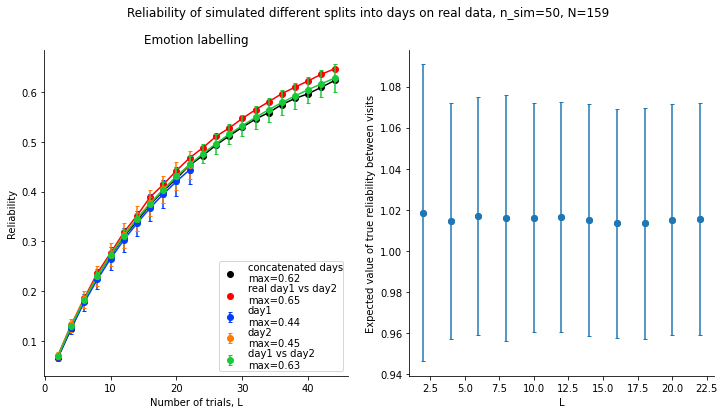

In [35]:

palette = sns.color_palette("bright", n_colors=3, as_cmap=False)

fig, axs = plt.subplots(1,2, figsize=(12,6))

# plt.subplots_adjust(hspace=0.4)

# add the full concatenated forms
axs[0].scatter(n_trials_list_emotion_labelling_concat, np.nanmean(array_corr_fxn_emotion_labelling_concat, axis=1), label=f'concatenated days\nmax={np.nanmean(array_corr_fxn_emotion_labelling_concat, axis=1).max():.2f}', color='k')
axs[0].plot(n_trials_list_emotion_labelling_concat, np.nanmean(array_corr_fxn_emotion_labelling_concat, axis=1), color='k')

# add the real split
axs[0].scatter(n_trials_list_emotion_labelling_orig_vs_rep_real, np.nanmean(array_corr_fxn_emotion_labelling_orig_vs_rep_real, axis=1), label=f'real day1 vs day2\nmax={np.nanmean(array_corr_fxn_emotion_labelling_orig_vs_rep_real, axis=1).max():.2f}', color='r')
axs[0].plot(n_trials_list_emotion_labelling_orig_vs_rep_real, np.nanmean(array_corr_fxn_emotion_labelling_orig_vs_rep_real, axis=1), color='r')


# plot the individual plots
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_emotion_labelling_orig, n_trials_list_emotion_labelling_orig, 'day1'),
    (array_corr_fxn_emotion_labelling_rep, n_trials_list_emotion_labelling_rep, 'day2'),
    (array_corr_fxn_emotion_labelling_orig_vs_rep, n_trials_list_emotion_labelling_orig_vs_rep, 'day1 vs day2'),
]):
    arr = np.nanmean(arr, axis=-1)
#     axs[0].scatter(x_list, np.nanmean(arr, axis=0), label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}', color=palette[i])
    axs[0].plot(x_list, np.nanmean(arr, axis=0), color=palette[i])
    axs[0].errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, 
                c=palette[i], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')



axs[0].legend(columnspacing=0.01, labelspacing=0.01, borderpad=0.05, loc='lower right')
# axs[0].set_title(f'{task}, N={tmp_dic["N"]}')


axs[0].set_ylabel('Reliability')
axs[0].set_xlabel('Number of trials, L')
axs[0].set_title('Emotion labelling')


# Add plot for the expected correlation
# check that the x ranges are the same
assert np.array_equal(n_trials_list_emotion_labelling_orig, n_trials_list_emotion_labelling_rep)
assert np.array_equal(n_trials_list_emotion_labelling_concat, n_trials_list_emotion_labelling_orig_vs_rep)


# # figure out maximal L that we have in both curves
# max_L = max(set(n_trials_list_emotion_labelling_orig)&set(n_trials_list_emotion_labelling_orig_vs_rep)) #max(np.intersect1d(tmp_dic['n_trials_list_emotion_labelling_orig'], tmp_dic['n_trials_list_emotion_labelling_orig_vs_rep']))


r_xy_array = np.zeros((n_splits, len(n_trials_list_emotion_labelling_orig)))

for i in range(n_splits):


    # get the true correlation
    r_xy_array[i] = get_true_correlation(
        np.nanmean(array_corr_fxn_emotion_labelling_orig_vs_rep[i, :len(n_trials_list_emotion_labelling_orig)], axis=1),
        np.nanmean(array_corr_fxn_emotion_labelling_orig[i], axis=1), 
        np.nanmean(array_corr_fxn_emotion_labelling_rep[i], axis=1)
    )


# save it
dic_true_reliabilities_tasks['Emotion labelling'] = r_xy_array


axs[1].scatter(n_trials_list_emotion_labelling_orig, r_xy_array.mean(axis=0))
axs[1].errorbar(n_trials_list_emotion_labelling_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
axs[1].set_ylabel('Expected value of true reliability between visits')
axs[1].set_xlabel('L')

sns.despine()
# axs[1].set_title(f'Expected true reliability between visits per tasks')


plt.suptitle(f'Reliability of simulated different splits into days on real data, n_sim={n_splits}, N={N_emotion_labelling}')
plt.show()

### Emotion matching
[top](#top)

In [36]:
# get car matching
df_emotion_matching = [x for x in dataframe_list if x.task.str.contains('emotion_matching').all()][0]

# do cleaning - drop participants whose difference in score on first and second step is large
# define threshold for removing outliers
std_thr = 2
# compute the score difference
tmp_score_diff = df_emotion_matching.loc[df_emotion_matching["form"]=="original", ["userID", "correct"]].groupby('userID').mean() - df_emotion_matching.loc[df_emotion_matching["form"]=="repetition", ["userID", "correct"]].groupby('userID').mean()
mu = tmp_score_diff.mean()[0]
std = tmp_score_diff.std()[0]
outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
df_emotion_matching_cleaned = df_emotion_matching[~df_emotion_matching['userID'].isin(outliers)]
print(f'Droping {len(outliers)} outliers')

N_emotion_matching = df_emotion_matching_cleaned['userID'].unique().size

# define the data
num_forms = 2
n_trials_per_form_emotion_matching = 61

# extract data
emotion_matching_concat = extract_data(df_emotion_matching_cleaned.loc[:, ['userID', 'correct']], 
                                   num_forms*n_trials_per_form_emotion_matching, measure="correct")

Droping 8 outliers


In [37]:
# set step separately
step = 3

# do concat array separately
array_corr_fxn_emotion_matching_concat, n_trials_list_emotion_matching_concat = calculate_reliability_between_two_groups(emotion_matching_concat, emotion_matching_concat, num_forms*n_trials_per_form_emotion_matching, step=step)


# define how many times to split the data
n_splits = 50
n_repeats = 10**3

# predefine arrays
array_corr_fxn_emotion_matching_orig = np.zeros((n_splits, 10, n_repeats))
array_corr_fxn_emotion_matching_rep = np.zeros((n_splits, 10, n_repeats))
array_corr_fxn_emotion_matching_orig_vs_rep = np.zeros((n_splits, 20, n_repeats))

# check 
assert n_trials_per_form_emotion_matching == emotion_matching_concat.shape[1]//2

# start the timer
start = time.time()

for s in range(n_splits):
    # define random splitter
    rng_split = np.random.default_rng(s)
    
    # split the data into two days
    random_idx = rng_split.choice(range(emotion_matching_concat.shape[1]), n_trials_per_form_emotion_matching, replace=False)
    random_idx2 = np.asarray(list(set(range(emotion_matching_concat.shape[1])) - set(random_idx)))
#     random_idx, random_idx2 = np.split(np.random.permutation(np.arange(emotion_matching_concat_shape)), 2)

    day1_array = emotion_matching_concat[:, random_idx]
    day2_array = emotion_matching_concat[:, random_idx2]

    ### Run analysis
    ## Short arrays
    array_corr_fxn_emotion_matching_orig[s], n_trials_list_emotion_matching_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_emotion_matching, n_repeats=n_repeats, step=step)
    array_corr_fxn_emotion_matching_rep[s], n_trials_list_emotion_matching_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_emotion_matching, n_repeats=n_repeats, step=step)

    ## Long arrays
    array_corr_fxn_emotion_matching_orig_vs_rep[s], n_trials_list_emotion_matching_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_emotion_matching, n_repeats=n_repeats, step=step)


# Add the real split
day1_array = extract_data(df_emotion_matching_cleaned.loc[df_emotion_matching_cleaned['form']=='original', ['userID', 'correct']], 
                                   n_trials_per_form_emotion_matching, measure="correct")
day2_array = extract_data(df_emotion_matching_cleaned.loc[df_emotion_matching_cleaned['form']=='repetition', ['userID', 'correct']], 
                                   n_trials_per_form_emotion_matching, measure="correct")

# ### Run analysis
# ## Short arrays
# array_corr_fxn_emotion_matching_orig_real, n_trials_list_emotion_matching_orig_real = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_emotion_matching, n_repeats=n_repeats)
# array_corr_fxn_emotion_matching_rep_real, n_trials_list_emotion_matching_rep_real = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_emotion_matching, n_repeats=n_repeats)

## Long arrays
array_corr_fxn_emotion_matching_orig_vs_rep_real, n_trials_list_emotion_matching_orig_vs_rep_real = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_emotion_matching, n_repeats=n_repeats)

    
print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")

Process took: 7.81 s which is 0.13 min.
Process took: 3.47 s which is 0.06 min.
Process took: 3.59 s which is 0.06 min.
Process took: 7.16 s which is 0.12 min.
Process took: 3.42 s which is 0.06 min.
Process took: 3.39 s which is 0.06 min.
Process took: 6.73 s which is 0.11 min.
Process took: 3.48 s which is 0.06 min.
Process took: 3.32 s which is 0.06 min.
Process took: 6.43 s which is 0.11 min.
Process took: 3.06 s which is 0.05 min.
Process took: 2.99 s which is 0.05 min.
Process took: 6.27 s which is 0.10 min.
Process took: 3.17 s which is 0.05 min.
Process took: 3.03 s which is 0.05 min.
Process took: 6.25 s which is 0.10 min.
Process took: 3.15 s which is 0.05 min.
Process took: 3.13 s which is 0.05 min.
Process took: 6.39 s which is 0.11 min.
Process took: 3.04 s which is 0.05 min.
Process took: 3.10 s which is 0.05 min.
Process took: 6.00 s which is 0.10 min.
Process took: 3.18 s which is 0.05 min.
Process took: 2.99 s which is 0.05 min.
Process took: 6.58 s which is 0.11 min.


/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Code/./functions/reliability_functions.py:591: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_first[:, random_idx], axis=1),


Process took: 3.09 s which is 0.05 min.
Process took: 3.09 s which is 0.05 min.
Process took: 6.05 s which is 0.10 min.
Process took: 3.20 s which is 0.05 min.
Process took: 2.99 s which is 0.05 min.
Process took: 6.07 s which is 0.10 min.
Process took: 3.07 s which is 0.05 min.
Process took: 3.03 s which is 0.05 min.
Process took: 6.37 s which is 0.11 min.
Process took: 3.09 s which is 0.05 min.
Process took: 3.16 s which is 0.05 min.
Process took: 7.35 s which is 0.12 min.
Process took: 3.24 s which is 0.05 min.
Process took: 3.40 s which is 0.06 min.
Process took: 6.56 s which is 0.11 min.
Process took: 3.38 s which is 0.06 min.
Process took: 3.11 s which is 0.05 min.
Process took: 6.05 s which is 0.10 min.
Process took: 2.94 s which is 0.05 min.
Process took: 3.13 s which is 0.05 min.
Process took: 6.20 s which is 0.10 min.
Process took: 3.18 s which is 0.05 min.
Process took: 3.14 s which is 0.05 min.
Process took: 6.26 s which is 0.10 min.
Process took: 3.01 s which is 0.05 min.


/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Code/./functions/reliability_functions.py:592: RuntimeWarning: Mean of empty slice
  np.nanmean(all_trials_arr_second[:, random_idx2], axis=1)


Process took: 3.25 s which is 0.05 min.
Process took: 6.42 s which is 0.11 min.
Process took: 3.18 s which is 0.05 min.
Process took: 3.03 s which is 0.05 min.
Process took: 6.29 s which is 0.10 min.
Process took: 3.11 s which is 0.05 min.
Process took: 3.16 s which is 0.05 min.
Process took: 6.59 s which is 0.11 min.
Process took: 2.96 s which is 0.05 min.
Process took: 3.08 s which is 0.05 min.
Process took: 6.59 s which is 0.11 min.
Process took: 3.13 s which is 0.05 min.
Process took: 3.10 s which is 0.05 min.
Process took: 6.31 s which is 0.11 min.
Process took: 2.97 s which is 0.05 min.
Process took: 2.91 s which is 0.05 min.
Process took: 6.17 s which is 0.10 min.
Process took: 3.16 s which is 0.05 min.
Process took: 3.20 s which is 0.05 min.
Process took: 6.40 s which is 0.11 min.
Process took: 3.12 s which is 0.05 min.
Process took: 3.12 s which is 0.05 min.
Process took: 6.08 s which is 0.10 min.
Process took: 3.00 s which is 0.05 min.
Process took: 3.14 s which is 0.05 min.


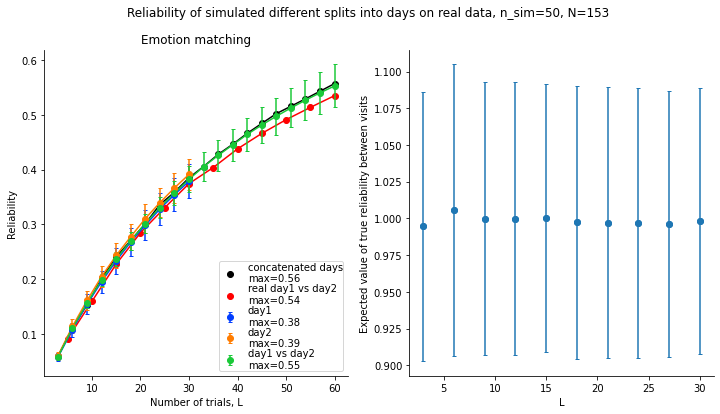

In [38]:
palette = sns.color_palette("bright", n_colors=3, as_cmap=False)

fig, axs = plt.subplots(1,2, figsize=(12,6))

# plt.subplots_adjust(hspace=0.4)

# add the full concatenated forms
axs[0].scatter(n_trials_list_emotion_matching_concat, np.nanmean(array_corr_fxn_emotion_matching_concat, axis=1), label=f'concatenated days\nmax={np.nanmean(array_corr_fxn_emotion_matching_concat, axis=1).max():.2f}', color='k')
axs[0].plot(n_trials_list_emotion_matching_concat, np.nanmean(array_corr_fxn_emotion_matching_concat, axis=1), color='k')

# add the real split
axs[0].scatter(n_trials_list_emotion_matching_orig_vs_rep_real, np.nanmean(array_corr_fxn_emotion_matching_orig_vs_rep_real, axis=1), label=f'real day1 vs day2\nmax={np.nanmean(array_corr_fxn_emotion_matching_orig_vs_rep_real, axis=1).max():.2f}', color='r')
axs[0].plot(n_trials_list_emotion_matching_orig_vs_rep_real, np.nanmean(array_corr_fxn_emotion_matching_orig_vs_rep_real, axis=1), color='r')

# plot the individual plots
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_emotion_matching_orig, n_trials_list_emotion_matching_orig, 'day1'),
    (array_corr_fxn_emotion_matching_rep, n_trials_list_emotion_matching_rep, 'day2'),
    (array_corr_fxn_emotion_matching_orig_vs_rep, n_trials_list_emotion_matching_orig_vs_rep, 'day1 vs day2'),
]):
    arr = np.nanmean(arr, axis=-1)
#     axs[0].scatter(x_list, np.nanmean(arr, axis=0), label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}', color=palette[i])
    axs[0].plot(x_list, np.nanmean(arr, axis=0), color=palette[i])
    axs[0].errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, 
                c=palette[i], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')



axs[0].legend(columnspacing=0.01, labelspacing=0.01, borderpad=0.05, loc='lower right')
# axs[0].set_title(f'{task}, N={tmp_dic["N"]}')


axs[0].set_ylabel('Reliability')
axs[0].set_xlabel('Number of trials, L')
axs[0].set_title('Emotion matching')


# Add plot for the expected correlation
# check that the x ranges are the same
assert np.array_equal(n_trials_list_emotion_matching_orig, n_trials_list_emotion_matching_rep)
assert np.array_equal(n_trials_list_emotion_matching_concat, n_trials_list_emotion_matching_orig_vs_rep)


# # figure out maximal L that we have in both curves
# max_L = max(set(n_trials_list_emotion_matching_orig)&set(n_trials_list_emotion_matching_orig_vs_rep)) #max(np.intersect1d(tmp_dic['n_trials_list_emotion_matching_orig'], tmp_dic['n_trials_list_emotion_matching_orig_vs_rep']))


r_xy_array = np.zeros((n_splits, len(n_trials_list_emotion_matching_orig)))

for i in range(n_splits):

    # get the true correlation
    r_xy_array[i] = get_true_correlation(
        np.nanmean(array_corr_fxn_emotion_matching_orig_vs_rep[i, :len(n_trials_list_emotion_matching_orig)], axis=1),
        np.nanmean(array_corr_fxn_emotion_matching_orig[i], axis=1), 
        np.nanmean(array_corr_fxn_emotion_matching_rep[i], axis=1)
    )

# save it
dic_true_reliabilities_tasks['Emotion matching'] = r_xy_array

axs[1].scatter(n_trials_list_emotion_matching_orig, r_xy_array.mean(axis=0))
axs[1].errorbar(n_trials_list_emotion_matching_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
axs[1].set_ylabel('Expected value of true reliability between visits')
axs[1].set_xlabel('L')

sns.despine()
# axs[1].set_title(f'Expected true reliability between visits per tasks')


plt.suptitle(f'Reliability of simulated different splits into days on real data, n_sim={n_splits}, N={N_emotion_matching}')
plt.show()

### GFMT
[top](#top)

In [39]:
# get car matching
df_GFMT = [x for x in dataframe_list if x.task.str.contains('GFMT').all()][0]

# do cleaning - drop participants whose difference in score on first and second step is large
# define threshold for removing outliers
std_thr = 2
# compute the score difference
tmp_score_diff = df_GFMT.loc[df_GFMT["form"]=="original", ["userID", "correct"]].groupby('userID').mean() - df_GFMT.loc[df_GFMT["form"]=="repetition", ["userID", "correct"]].groupby('userID').mean()
mu = tmp_score_diff.mean()[0]
std = tmp_score_diff.std()[0]
outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
df_GFMT_cleaned = df_GFMT[~df_GFMT['userID'].isin(outliers)]
print(f'Droping {len(outliers)} outliers')

N_GFMT = df_GFMT_cleaned['userID'].unique().size

# define the data
num_forms = 2
n_trials_per_form_GFMT = 40

# extract data
GFMT_concat = extract_data(df_GFMT_cleaned.loc[:, ['userID', 'correct']], 
                                   num_forms*n_trials_per_form_GFMT, measure="correct")


Droping 6 outliers


In [40]:
# do concat array separately

array_corr_fxn_GFMT_concat, n_trials_list_GFMT_concat = calculate_reliability_between_two_groups(GFMT_concat, GFMT_concat, num_forms*n_trials_per_form_GFMT)


# define how many times to split the data
n_splits = 50
n_repeats = 10**3

# predefine arrays
array_corr_fxn_GFMT_orig = np.zeros((n_splits, 10, n_repeats))
array_corr_fxn_GFMT_rep = np.zeros((n_splits, 10, n_repeats))
array_corr_fxn_GFMT_orig_vs_rep = np.zeros((n_splits, 20, n_repeats))

# check 
assert n_trials_per_form_GFMT == GFMT_concat.shape[1]//2

# start the timer
start = time.time()

for s in range(n_splits):
    # define random splitter
    rng_split = np.random.default_rng(s)
    
    # split the data into two days
    random_idx = rng_split.choice(range(GFMT_concat.shape[1]), n_trials_per_form_GFMT, replace=False)
    random_idx2 = np.asarray(list(set(range(GFMT_concat.shape[1])) - set(random_idx)))
#     random_idx, random_idx2 = np.split(np.random.permutation(np.arange(GFMT_concat_shape)), 2)

    day1_array = GFMT_concat[:, random_idx]
    day2_array = GFMT_concat[:, random_idx2]

    ### Run analysis
    ## Short arrays
    array_corr_fxn_GFMT_orig[s], n_trials_list_GFMT_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_GFMT, n_repeats=n_repeats)
    array_corr_fxn_GFMT_rep[s], n_trials_list_GFMT_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_GFMT, n_repeats=n_repeats)

    ## Long arrays
    array_corr_fxn_GFMT_orig_vs_rep[s], n_trials_list_GFMT_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_GFMT, n_repeats=n_repeats)



    
# Add the real data, real split
day1_array = extract_data(df_GFMT_cleaned.loc[df_GFMT_cleaned['form']=='original', ['userID', 'correct']], 
                                   n_trials_per_form_GFMT, measure="correct")
day2_array = extract_data(df_GFMT_cleaned.loc[df_GFMT_cleaned['form']=='repetition', ['userID', 'correct']], 
                                   n_trials_per_form_GFMT, measure="correct")

# ### Run analysis
# ## Short arrays
# array_corr_fxn_GFMT_orig_real, n_trials_list_GFMT_orig_real = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_GFMT, n_repeats=n_repeats)
# array_corr_fxn_GFMT_rep_real, n_trials_list_GFMT_rep_real = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_GFMT, n_repeats=n_repeats)

## Long arrays
array_corr_fxn_GFMT_orig_vs_rep_real, n_trials_list_GFMT_orig_vs_rep_real = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_GFMT, n_repeats=n_repeats)



print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")



Process took: 6.62 s which is 0.11 min.
Process took: 2.99 s which is 0.05 min.
Process took: 3.01 s which is 0.05 min.
Process took: 5.94 s which is 0.10 min.
Process took: 2.93 s which is 0.05 min.
Process took: 2.84 s which is 0.05 min.
Process took: 5.69 s which is 0.09 min.
Process took: 2.85 s which is 0.05 min.
Process took: 2.87 s which is 0.05 min.
Process took: 5.95 s which is 0.10 min.
Process took: 2.91 s which is 0.05 min.
Process took: 2.90 s which is 0.05 min.
Process took: 6.36 s which is 0.11 min.
Process took: 3.10 s which is 0.05 min.
Process took: 3.16 s which is 0.05 min.
Process took: 6.46 s which is 0.11 min.
Process took: 3.32 s which is 0.06 min.
Process took: 3.05 s which is 0.05 min.
Process took: 6.16 s which is 0.10 min.
Process took: 3.10 s which is 0.05 min.
Process took: 3.08 s which is 0.05 min.
Process took: 6.15 s which is 0.10 min.
Process took: 3.07 s which is 0.05 min.
Process took: 3.22 s which is 0.05 min.
Process took: 6.43 s which is 0.11 min.


#### Plot 

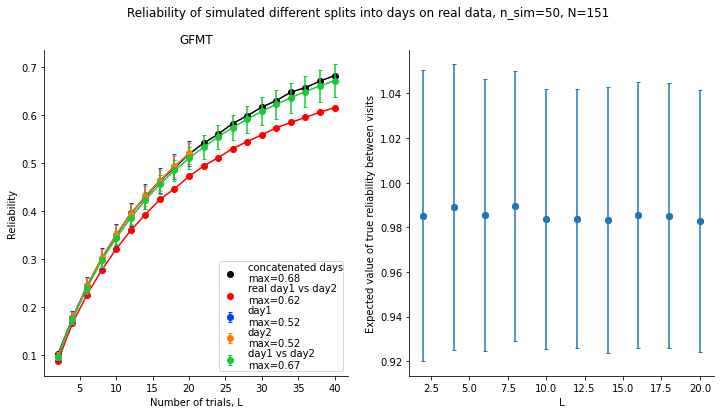

In [41]:
palette = sns.color_palette("bright", n_colors=3, as_cmap=False)

fig, axs = plt.subplots(1,2, figsize=(12,6))

# plt.subplots_adjust(hspace=0.4)

# add the full concatenated forms
axs[0].scatter(n_trials_list_GFMT_concat, np.nanmean(array_corr_fxn_GFMT_concat, axis=1), label=f'concatenated days\nmax={np.nanmean(array_corr_fxn_GFMT_concat, axis=1).max():.2f}', color='k')
axs[0].plot(n_trials_list_GFMT_concat, np.nanmean(array_corr_fxn_GFMT_concat, axis=1), color='k')

# add the real split
axs[0].scatter(n_trials_list_GFMT_orig_vs_rep_real, np.nanmean(array_corr_fxn_GFMT_orig_vs_rep_real, axis=1), label=f'real day1 vs day2\nmax={np.nanmean(array_corr_fxn_GFMT_orig_vs_rep_real, axis=1).max():.2f}', color='r')
axs[0].plot(n_trials_list_GFMT_orig_vs_rep_real, np.nanmean(array_corr_fxn_GFMT_orig_vs_rep_real, axis=1), color='r')

# plot the individual plots
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_GFMT_orig, n_trials_list_GFMT_orig, 'day1'),
    (array_corr_fxn_GFMT_rep, n_trials_list_GFMT_rep, 'day2'),
    (array_corr_fxn_GFMT_orig_vs_rep, n_trials_list_GFMT_orig_vs_rep, 'day1 vs day2'),
]):
    arr = np.nanmean(arr, axis=-1)
#     axs[0].scatter(x_list, np.nanmean(arr, axis=0), label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}', color=palette[i])
    axs[0].plot(x_list, np.nanmean(arr, axis=0), color=palette[i])
    axs[0].errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, 
                c=palette[i], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')



axs[0].legend(columnspacing=0.01, labelspacing=0.01, borderpad=0.05)
# axs[0].set_title(f'{task}, N={tmp_dic["N"]}')


axs[0].set_ylabel('Reliability')
axs[0].set_xlabel('Number of trials, L')
axs[0].set_title('GFMT')


# Add plot for the expected correlation
# check that the x ranges are the same
assert np.array_equal(n_trials_list_GFMT_orig, n_trials_list_GFMT_rep)
assert np.array_equal(n_trials_list_GFMT_concat, n_trials_list_GFMT_orig_vs_rep)


# # figure out maximal L that we have in both curves
# max_L = max(set(n_trials_list_GFMT_orig)&set(n_trials_list_GFMT_orig_vs_rep)) #max(np.intersect1d(tmp_dic['n_trials_list_GFMT_orig'], tmp_dic['n_trials_list_GFMT_orig_vs_rep']))


r_xy_array = np.zeros((n_splits, len(n_trials_list_GFMT_orig)))

for i in range(n_splits):


    # get the true correlation
    r_xy_array[i] = get_true_correlation(
        np.nanmean(array_corr_fxn_GFMT_orig_vs_rep[i, :len(n_trials_list_GFMT_orig)], axis=1),
        np.nanmean(array_corr_fxn_GFMT_orig[i], axis=1), 
        np.nanmean(array_corr_fxn_GFMT_rep[i], axis=1)
    )

# save it
dic_true_reliabilities_tasks['GMFT'] = r_xy_array

axs[1].scatter(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0))
axs[1].errorbar(n_trials_list_GFMT_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
axs[1].set_ylabel('Expected value of true reliability between visits')
axs[1].set_xlabel('L')

sns.despine()
# axs[1].set_title(f'Expected true reliability between visits per tasks')


plt.suptitle(f'Reliability of simulated different splits into days on real data, n_sim={n_splits}, N={N_GFMT}')
plt.show()

### PIM MC
[top](#top)

In [42]:
# get PIM
df_PIM_MC = [x for x in dataframe_list if x.task.str.contains('PIM_MC').all()][0]
df_PIM_MC = pd.melt(df_PIM_MC[['userID', 'hobby', 'vice', 'code_name', 'country', 'form']], 
                  id_vars=['userID', 'form'], value_name='correct')

# do cleaning - drop participants whose difference in score on first and second step is large
# define threshold for removing outliers
std_thr = 2
# compute the score difference
tmp_score_diff = df_PIM_MC.loc[df_PIM_MC["form"]=="original", ["userID", "correct"]].groupby('userID').mean() - df_PIM_MC.loc[df_PIM_MC["form"]=="repetition", ["userID", "correct"]].groupby('userID').mean()
mu = tmp_score_diff.mean()[0]
std = tmp_score_diff.std()[0]
outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
df_PIM_MC_cleaned = df_PIM_MC[~df_PIM_MC['userID'].isin(outliers)].sort_values(by=['userID', 'variable', 'form'], kind='stable', ignore_index=True)
print(f'Droping {len(outliers)} outliers')

N_PIM_MC = df_PIM_MC_cleaned['userID'].unique().size

# define the data
num_forms = 2
n_trials_per_form_PIM_MC = 24*4

# extract data
PIM_MC_concat = extract_data(df_PIM_MC_cleaned.loc[:, ['userID', 'correct']], 
                                   num_forms*n_trials_per_form_PIM_MC, measure="correct")

Droping 8 outliers


In [43]:
# set step separately
step = 4

# do concat array separately
array_corr_fxn_PIM_MC_concat, n_trials_list_PIM_MC_concat = calculate_reliability_between_two_groups(PIM_MC_concat, PIM_MC_concat, num_forms*n_trials_per_form_PIM_MC, step=step)


# define how many times to split the data
n_splits = 50
n_repeats = 10**3

# predefine arrays
array_corr_fxn_PIM_MC_orig = np.zeros((n_splits, 12, n_repeats))
array_corr_fxn_PIM_MC_rep = np.zeros((n_splits, 12, n_repeats))
array_corr_fxn_PIM_MC_orig_vs_rep = np.zeros((n_splits, 24, n_repeats))

# check 
assert n_trials_per_form_PIM_MC == PIM_MC_concat.shape[1]//2

# start the timer
start = time.time()

for s in range(n_splits):
    # define random splitter
    rng_split = np.random.default_rng(s)
    
    # split the data into two days
    random_idx = rng_split.choice(range(PIM_MC_concat.shape[1]), n_trials_per_form_PIM_MC, replace=False)
    random_idx2 = np.asarray(list(set(range(PIM_MC_concat.shape[1])) - set(random_idx)))
#     random_idx, random_idx2 = np.split(np.random.permutation(np.arange(PIM_MC_concat_shape)), 2)

    day1_array = PIM_MC_concat[:, random_idx]
    day2_array = PIM_MC_concat[:, random_idx2]

    ### Run analysis
    ## Short arrays
    array_corr_fxn_PIM_MC_orig[s], n_trials_list_PIM_MC_orig = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_PIM_MC, n_repeats=n_repeats, step=step)
    array_corr_fxn_PIM_MC_rep[s], n_trials_list_PIM_MC_rep = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_PIM_MC, n_repeats=n_repeats, step=step)

    ## Long arrays
    array_corr_fxn_PIM_MC_orig_vs_rep[s], n_trials_list_PIM_MC_orig_vs_rep = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_PIM_MC, n_repeats=n_repeats, step=step)


# Add the real data, real split
day1_array = extract_data(df_PIM_MC_cleaned.loc[df_PIM_MC_cleaned['form']=='original', ['userID', 'correct']], 
                                   n_trials_per_form_PIM_MC, measure="correct")
day2_array = extract_data(df_PIM_MC_cleaned.loc[df_PIM_MC_cleaned['form']=='repetition', ['userID', 'correct']], 
                                   n_trials_per_form_PIM_MC, measure="correct")

# ### Run analysis
# ## Short arrays
# array_corr_fxn_PIM_MC_orig_real, n_trials_list_PIM_MC_orig_real = calculate_reliability_between_two_groups(day1_array, day1_array, n_trials_per_form_PIM_MC, n_repeats=n_repeats)
# array_corr_fxn_PIM_MC_rep_real, n_trials_list_PIM_MC_rep_real = calculate_reliability_between_two_groups(day2_array, day2_array, n_trials_per_form_PIM_MC, n_repeats=n_repeats)

## Long arrays
array_corr_fxn_PIM_MC_orig_vs_rep_real, n_trials_list_PIM_MC_orig_vs_rep_real = calculate_reliability_between_two_groups(day1_array, day2_array, num_forms*n_trials_per_form_PIM_MC, n_repeats=n_repeats)


print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")


Process took: 7.84 s which is 0.13 min.
Process took: 3.28 s which is 0.05 min.
Process took: 3.50 s which is 0.06 min.
Process took: 7.05 s which is 0.12 min.
Process took: 3.35 s which is 0.06 min.
Process took: 3.30 s which is 0.05 min.
Process took: 6.62 s which is 0.11 min.
Process took: 3.20 s which is 0.05 min.
Process took: 3.18 s which is 0.05 min.
Process took: 6.56 s which is 0.11 min.
Process took: 3.27 s which is 0.05 min.
Process took: 3.28 s which is 0.05 min.
Process took: 6.55 s which is 0.11 min.
Process took: 3.25 s which is 0.05 min.
Process took: 3.22 s which is 0.05 min.
Process took: 6.72 s which is 0.11 min.
Process took: 3.22 s which is 0.05 min.
Process took: 3.20 s which is 0.05 min.
Process took: 6.55 s which is 0.11 min.
Process took: 3.19 s which is 0.05 min.
Process took: 3.24 s which is 0.05 min.
Process took: 6.55 s which is 0.11 min.
Process took: 3.22 s which is 0.05 min.
Process took: 3.19 s which is 0.05 min.
Process took: 6.58 s which is 0.11 min.


#### Plot

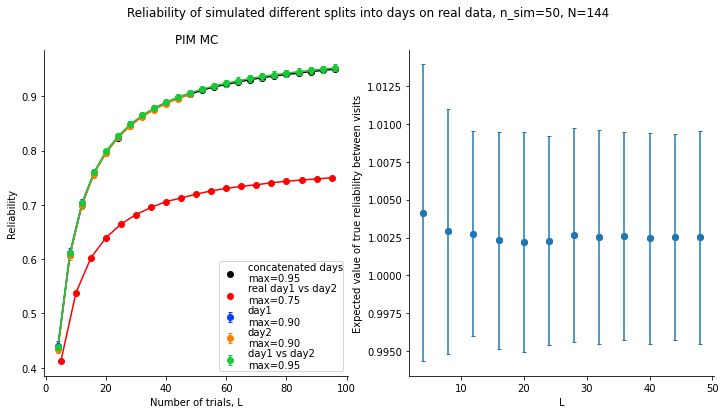

In [44]:
palette = sns.color_palette("bright", n_colors=3, as_cmap=False)

fig, axs = plt.subplots(1,2, figsize=(12,6))

# plt.subplots_adjust(hspace=0.4)

# add the full concatenated forms
axs[0].scatter(n_trials_list_PIM_MC_concat, np.nanmean(array_corr_fxn_PIM_MC_concat, axis=1), label=f'concatenated days\nmax={np.nanmean(array_corr_fxn_PIM_MC_concat, axis=1).max():.2f}', color='k')
axs[0].plot(n_trials_list_PIM_MC_concat, np.nanmean(array_corr_fxn_PIM_MC_concat, axis=1), color='k')

# add the real split
axs[0].scatter(n_trials_list_PIM_MC_orig_vs_rep_real, np.nanmean(array_corr_fxn_PIM_MC_orig_vs_rep_real, axis=1), label=f'real day1 vs day2\nmax={np.nanmean(array_corr_fxn_PIM_MC_orig_vs_rep_real, axis=1).max():.2f}', color='r')
axs[0].plot(n_trials_list_PIM_MC_orig_vs_rep_real, np.nanmean(array_corr_fxn_PIM_MC_orig_vs_rep_real, axis=1), color='r')

# plot the individual plots
for i, (arr, x_list, label) in enumerate([
    (array_corr_fxn_PIM_MC_orig, n_trials_list_PIM_MC_orig, 'day1'),
    (array_corr_fxn_PIM_MC_rep, n_trials_list_PIM_MC_rep, 'day2'),
    (array_corr_fxn_PIM_MC_orig_vs_rep, n_trials_list_PIM_MC_orig_vs_rep, 'day1 vs day2'),
]):
    arr = np.nanmean(arr, axis=-1)
#     axs[0].scatter(x_list, np.nanmean(arr, axis=0), label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}', color=palette[i])
    axs[0].plot(x_list, np.nanmean(arr, axis=0), color=palette[i])
    axs[0].errorbar(x_list, np.nanmean(arr, axis=0), yerr=np.nanstd(arr, axis=0), fmt='o', capsize=2, 
                c=palette[i], label=f'{label}\nmax={np.nanmean(arr, axis=0).max():.2f}')



axs[0].legend(columnspacing=0.01, labelspacing=0.01, borderpad=0.05)
# axs[0].set_title(f'{task}, N={tmp_dic["N"]}')


axs[0].set_ylabel('Reliability')
axs[0].set_xlabel('Number of trials, L')
axs[0].set_title('PIM MC')


# Add plot for the expected correlation
# check that the x ranges are the same
assert np.array_equal(n_trials_list_PIM_MC_orig, n_trials_list_PIM_MC_rep)
assert np.array_equal(n_trials_list_PIM_MC_concat, n_trials_list_PIM_MC_orig_vs_rep)


# # figure out maximal L that we have in both curves
# max_L = max(set(n_trials_list_PIM_MC_orig)&set(n_trials_list_PIM_MC_orig_vs_rep)) #max(np.intersect1d(tmp_dic['n_trials_list_PIM_MC_orig'], tmp_dic['n_trials_list_PIM_MC_orig_vs_rep']))


r_xy_array = np.zeros((n_splits, len(n_trials_list_PIM_MC_orig)))

for i in range(n_splits):


    # get the true correlation
    r_xy_array[i] = get_true_correlation(
        np.nanmean(array_corr_fxn_PIM_MC_orig_vs_rep[i, :len(n_trials_list_PIM_MC_orig)], axis=1),
        np.nanmean(array_corr_fxn_PIM_MC_orig[i], axis=1), 
        np.nanmean(array_corr_fxn_PIM_MC_rep[i], axis=1)
    )

# save it
dic_true_reliabilities_tasks['PIM MC'] = r_xy_array

axs[1].scatter(n_trials_list_PIM_MC_orig, r_xy_array.mean(axis=0))
axs[1].errorbar(n_trials_list_PIM_MC_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
axs[1].set_ylabel('Expected value of true reliability between visits')
axs[1].set_xlabel('L')

sns.despine()
# axs[1].set_title(f'Expected true reliability between visits per tasks')


plt.suptitle(f'Reliability of simulated different splits into days on real data, n_sim={n_splits}, N={N_PIM_MC}')
plt.show()

### Get to know the SD
[top](#top)

The range here is way too different and variable to be effectively used. 

In [55]:
for task, n_trials_list in zip(dic_true_reliabilities_tasks.keys(), [
    n_trials_list_car_matching_orig,
    n_trials_list_emotion_labelling_orig,
    n_trials_list_emotion_matching_orig,
    n_trials_list_GFMT_orig,
    n_trials_list_PIM_MC_orig
]):
    arr = dic_true_reliabilities_tasks[task]
    print(task)
    # get index of where it's 20
    index = np.abs(n_trials_list - 20).argmin()
    for k in range(1,4):
        print(f'{k} SD: {(arr.mean(axis=0)-k*np.nanstd(arr, axis=0))[index]:.2f} - {(arr.mean(axis=0)+k*np.nanstd(arr, axis=0))[index]:.2f}')
    print(f'5-95 percentile: {np.percentile(arr, 5, axis=0)[index]:.2f} - {np.percentile(arr, 95, axis=0)[index]:.2f}')
    print(f'1-99 percentile: {np.percentile(arr, 1, axis=0)[index]:.2f} - {np.percentile(arr, 99, axis=0)[index]:.2f}')
#     for k in range(1,4):
#         print(f'{k} SD: {arr.mean(axis=0)-k*np.nanstd(arr, axis=0)} - {arr.mean(axis=0)+k*np.nanstd(arr, axis=0)}')
        

Emotion labelling
1 SD: 0.96 - 1.07
2 SD: 0.90 - 1.13
3 SD: 0.85 - 1.18
5-95 percentile: 0.92 - 1.09
1-99 percentile: 0.90 - 1.12
Emotion matching
1 SD: 0.91 - 1.09
2 SD: 0.82 - 1.18
3 SD: 0.73 - 1.27
5-95 percentile: 0.86 - 1.13
1-99 percentile: 0.85 - 1.17
GMFT
1 SD: 0.92 - 1.04
2 SD: 0.86 - 1.10
3 SD: 0.80 - 1.16
5-95 percentile: 0.87 - 1.07
1-99 percentile: 0.84 - 1.08
PIM MC
1 SD: 1.00 - 1.01
2 SD: 0.99 - 1.02
3 SD: 0.98 - 1.02
5-95 percentile: 0.99 - 1.01
1-99 percentile: 0.99 - 1.02
Car matching
1 SD: 0.96 - 1.05
2 SD: 0.92 - 1.09
3 SD: 0.88 - 1.14
5-95 percentile: 0.95 - 1.08
1-99 percentile: 0.91 - 1.09


In [46]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Mon Dec 18 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 23.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

pandas    : 1.2.4
sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
matplotlib: 3.6.2
numpy     : 1.19.1
seaborn   : 0.11.1



[top](#top)